In [230]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
import pandas as pd
from scipy import signal,interpolate
import os
import shutil

import wfdb

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [231]:
# 定义求RR间期的函数
def RR(signal,fs_raw=250):
    rr = [] #用来存储RR间期的数组
    R_pot = [] #用来存储满足条件R点的数组
    for index,value in enumerate(signal):
        if(index>0):
            rr_pot = (value-signal[index-1])/fs_raw
            #去除异常的RR间期数值，保留[0.3,1.5]区间的数值
            if(rr_pot < 1.5 and rr_pot >0.3):
                rr.append(rr_pot)
                R_pot.append(value)
    return rr,R_pot
# 线性内插函数
def Interplt(rr, R_pot,fs=250):            
    x = np.array(R_pot)/fs
    y = rr
    tck = interpolate.splrep(x, y, s=0)
    t = 8*60 # 8min片段
    xnew = np.arange(0,t,0.5)
    ynew = interpolate.splev(xnew, tck, der=0)
    return xnew,ynew

# 将睡眠标签及8分钟观察数据追加进数组data_for_train
def write_tag_observation(file,a_refer=9):
    # 计算有效区间
    obsv_rr = RR_final(file)
    a = valid(obsv_rr) #file的有效区间
    
    # 计算RR间期
    record = wfdb.rdrecord(file, channels=[0])
    ann_ecg = wfdb.rdann(file,'ecg')
    ann_st = wfdb.rdann(file,'st')

    # print(ann_st.aux_note[:10])
    st = [] #用来存储睡眠状态标签的数组
    for aux_note in ann_st.aux_note:
        st.append(aux_note.split(" ")[0])
    fs = record.fs       

    # 将MT（Moment time 运动状态替换为W）
    for index, value in enumerate(st):
        if value=='MT':
            st[index]='W'

    # slp01a 共有len(st)=240个睡眠分期，因为选取的RIS序列为包含该睡眠分期的T=8min片段，因此可训练睡眠分期共有240-15=225个，即st[15:len(st)]
    # 观察值序列分别为[0,8min],[0.5,8.5min],[1,9min]...共225个片段对应的经过插值滤波后的8分钟RR间期，下面给出实现代码

    T = 8
#     fs = 250
    min_sample = 60*fs

    data_for_train = []
    for st_num in range(len(st)-2*T+1):
        sig_start = 0.5*st_num*min_sample
        sig_end = (T+0.5*st_num)*min_sample
        hmm_rr_st_index = []
        for index,value in enumerate(ann_ecg.sample):
            if(value >= sig_start and value <= sig_end):
                hmm_rr_st_index.append(index)
        hmm_rr_st = ann_ecg.sample[hmm_rr_st_index[0]:hmm_rr_st_index[-1]] # 每个睡眠分期对应的T=8分钟RR间期索引序列

        # 获取RR间期序列，并重采样
        st_rr,st_R_pot = RR(hmm_rr_st,fs)
        
        st_R_pot = st_R_pot-st_R_pot[0]
        hmm_rr_st = Interplt(st_rr,st_R_pot)[1] #三次样条插值函数Interplt
        
        hmm_rr_st_num = hmm_rr_st - signal.medfilt(hmm_rr_st,101) #将滤波后的RR间期序列赋给对应睡眠分期的观测值
        hmm_obsv_rr = []
        #限幅和编码
        for value in hmm_rr_st_num:
            if(value < -0.3):
                value = -37 #int(-0.3*1000/8)
            elif(value > 0.3):
                value = 37 #int(0.3*1000/8)
            else:
                value = int(1000*value/8)
            value = int(value*a_refer/a) #标准化
            hmm_obsv_rr.append(value)

        data_for_train.append([st[st_num+2*T-1],hmm_obsv_rr]) #将睡眠标签及对应8分钟观察值存进数组data_for_train
    return data_for_train

# 存储滤波、限幅编码后的RR间期序列，为通过直方图匹配变换来消除不同个体RR间期差异做准备
def RR_final(file):
    # 计算RR间期
    record = wfdb.rdrecord(file, channels=[0])
    ann_ecg = wfdb.rdann(file,'ecg')
    ann_st = wfdb.rdann(file,'st')

    # print(ann_st.aux_note[:10]）
    st = [] #用来存储睡眠状态标签的数组
    for aux_note in ann_st.aux_note:
        st.append(aux_note.split(" ")[0])
    fs = record.fs
    rr,r_pot = RR(ann_ecg.sample,fs)          

    # 将MT（Moment time 运动状态替换为W）
    for index, value in enumerate(st):
        if value=='MT':
            st[index]='W'
            
    
    #三次样条插值函数Interplt
    x = np.array(r_pot)/record.fs
    y = rr
    tck = interpolate.splrep(x, y, s=0)
    t = record.sig_len/record.fs      #信号长度（s）
    xnew = np.arange(0,t,0.5)
    rr_new = interpolate.splev(xnew, tck, der=0)
        
        
    rr_filt = rr_new - signal.medfilt(rr_new,101) #将滤波后的RR间期序列赋给对应睡眠分期的观测值
    obsv_rr = []
    #限幅和编码
    for value in rr_filt:
        if(value < -0.3):
            value = -37 #int(-0.3*1000/8)
        elif(value > 0.3):
            value = 37 #int(0.3*1000/8)
        else:
            value = int(1000*value/8)
        obsv_rr.append(value)

    return obsv_rr

# 为消除不同个体差异应用直方图匹配法：先寻找hmm_obsv_rr的90%有效区间[-a,a]
def valid(obsv_rr):
    for a in range(37):
        count_a = 0 # 将介于区间[-a,a]的r计数，初始化为0
        for r in obsv_rr:
            if(r > -a and r < a):
                count_a += 1
        if(count_a > 0.9*len(obsv_rr)):
            choose_a = count_a
            break
    return a # 即90%的点落在[-a,a]之间    

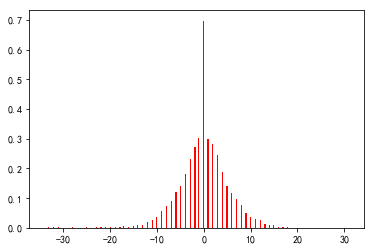

KstestResult(statistic=0.3162776458295986, pvalue=0.0)
(0.9565344452857971, 0.0)
9


In [232]:
from scipy.stats import kstest
from scipy import stats

# 直方图匹配变换
file_refer = 'slp01a'#参考系
cwd = os.getcwd()
file = os.path.join(cwd, 'slpdb_dl_dir', file_refer)
obsv_rr = RR_final(file)

x = obsv_rr
plt.hist(x, bins=256, normed=1,edgecolor='None',facecolor='red')  #画出x的直方图
plt.show()
test_stat1 = kstest(x, 'norm') #p-value=0<0.05,拒绝假设，假设不成立（x不服从正态分布）,GaussianHMM不适应，考虑MultinomialHMM
print(test_stat1)

print(stats.shapiro(x))#第二个为p值，<0.5,不服从正态分布

refer_a = valid(obsv_rr)
print(refer_a)

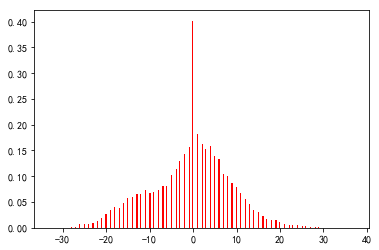

17


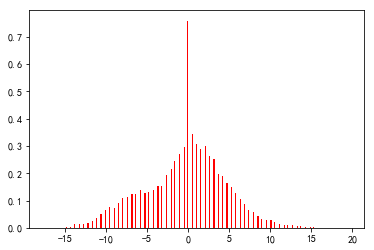

9


In [256]:
# 直方图匹配变换
file_deal = 'slp67x'#待处理系
cwd = os.getcwd()
file = os.path.join(cwd, 'slpdb_dl_dir', file_deal)
obsv_rr = RR_final(file)

x = obsv_rr
plt.hist(x, bins=256, normed=1,edgecolor='None',facecolor='red')  #画出x的直方图
plt.show()

# 为消除不同个体差异应用直方图匹配法：先寻找hmm_obsv_rr的90%有效区间[-a,a]
a = valid(obsv_rr)
obsv_rr_deal = np.array(obsv_rr)*refer_a/a
print(a)

x = obsv_rr_deal
plt.hist(x, bins=256, normed=1,edgecolor='None',facecolor='red')  #画出x的直方图
plt.show()
b = valid(obsv_rr_deal)
print(b)

In [234]:
## 预处理模块：将不同睡眠分期状态及对应的RIS观察值写进文件hmm_obsv.txt
cwd = os.getcwd()
HMM_data_path = os.path.join(cwd, 'HMM_train')
# HMM_data_path = cwd +"\\HMM_data"
folder = os.path.exists(HMM_data_path)  
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹  
    os.makedirs(HMM_data_path)            #makedirs 创建文件时如果路径不存在会创建这个路径  
    print ("---  New folder...  ---")  
    print ("---  OK  ---" ) 
else:  
    print ("---  There is this folder!  ---" ) 

file_obsv =  os.path.join(HMM_data_path, 'hmm_obsv.txt') 
file_test =  os.path.join(HMM_data_path, 'hmm_test.txt') 

---  There is this folder!  ---


In [235]:
# 批量读取slpdb_dl_dir下.dat文件,并写入
# display(os.listdir('slpdb_dl_dir'))
file_batch = ['slp01a', 'slp01b', 'slp02a', 'slp02b', 'slp04', 'slp32', 'slp41', 'slp48', 'slp60', 'slp67x']
# file_batch = ['slp03'] #最后一个睡眠标签位置大于RR间期，需要去除最后一个睡眠标签，作为测试样本
fid = open(file_obsv,"w")
for file_alone in file_batch:
    file = os.path.join(cwd, 'slpdb_dl_dir', file_alone)
    print("Writing data of:",file)
    data_for_train = write_tag_observation(file)
    
    for line in data_for_train:
        fid.write(line[0]+",")
        for content in line[1]:
            fid.write(str(content)+",")
        fid.write("\n")
        
fid.close()

Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp01a
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp01b
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp02a
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp02b
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp04
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp32
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp41
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp48
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp60
Writing data of: C:\Users\Administrator\task\hrv\sleepdetect\slpdb_dl_dir\slp67x


In [236]:
observations = list(range(-37,38))
Dic_observations = {observations[i]:i for i in range(75)}
stations = ['1','2','3','4','R','W']

In [237]:
## 读取睡眠标签及观察值序列文件hmm_obsv.txt
file =  os.path.join(HMM_data_path, 'hmm_obsv.txt') 
fid = open(file,"r")
note = fid.readlines()
fid.close()

states = [] # 存储hmm_obsv.txt的睡眠标签

T = 960 
observations_data= np.empty((len(note),T)) #用来存储观察值序列的矩阵，每行为一个观察值序列，每个序列长度固定为T=960

Ti = 0

for line in note:
    line_rr = line.split(",")
    states.append(line_rr[0][0])#将睡眠标签写进states数组,最后一个[0]是为了去空格
    
    line_new = [] # 对应RR间期
    for content in line_rr[1:-1]:  #去掉第一位标签，最后一位换行符
        line_new.append(int(content))#int 的作用是将str转为int

#     print(line_rr[0])
#     print(line_new)
#     print("==================")

    # 为了保证观察序列长度一致，设置观察序列长度T=2*60*8=960，因此从序列最后开始倒数选取T个观察值(需要重写此处，因为每个观察值列都为960)
    #（why倒数选取T个观察值：因为越后面的RR间期越能反应当前的睡眠分期）
    line_new = line_new[-T:]
    observations_data[Ti:] = line_new
    Ti+=1

print(observations_data)

[[ 0.  2.  4. ... 10. 18. 31.]
 [ 1.  0.  0. ...  9.  3.  0.]
 [17. 12. 12. ...  0.  0.  0.]
 ...
 [ 6.  5.  2. ...  4.  9. 17.]
 [10.  9.  6. ...  0.  0.  0.]
 [ 0.  0.  0. ...  3.  3.  2.]]


In [238]:
stations = ['1','2','3','4','R','W']
count_stations = np.zeros(6)
i = 0
for station_alone in stations:
    count_stations[i] = states.count(station_alone)
    i+=1
print(count_stations)
print(sum(count_stations))

[ 975. 1690.  141.   73.  319. 1646.]
4844.0


In [239]:
observations_1 = np.empty((int(count_stations[0]),T))
observations_2 = np.empty((int(count_stations[1]),T))
observations_3 = np.empty((int(count_stations[2]),T))
observations_4 = np.empty((int(count_stations[3]),T))
observations_R = np.empty((int(count_stations[4]),T))
observations_W = np.empty((int(count_stations[5]),T))
observations_matrix = [observations_1, observations_2, observations_3, observations_4, observations_R, observations_W]

In [240]:
for i in range(6):
    line = 0
    for index,value in enumerate(states):
        if(value==stations[i]):
            observations_matrix[i][line] = observations_data[index]
            line+=1            
    

In [242]:
## 利用Baum-Welch算法求解HMM模型参数(HMM问题二),分别训练6个模型
# 由于Baum-Welch(鲍姆-韦尔奇)算法是基于EM算法的近似算法，所以我们需要多跑几次，比如下面我们跑三次，选择一个比较优的模型参数，代码如下：
import numpy as np
from hmmlearn import hmm
from sklearn.externals import joblib
import warnings
warnings.filterwarnings("ignore")

# class hmmlearn.hmm.GaussianHMM(n_components=1, covariance_type='diag', min_covar=0.001, startprob_prior=1.0, transmat_prior=1.0, 
#                                means_prior=0, means_weight=0, covars_prior=0.01, covars_weight=1,algorithm='viterbi', 
#                                random_state=None, n_iter=10, tol=0.01, verbose=False, params='stmc', init_params='stmc')
                               
n_states = len(stations)

# 因为下面使用GaussianHMM，不需要给出observations，及对应的索引
# observations = list(range(-37,38))
# Dic_observations = {observations[i]:i for i in range(75)}
# observations_data_index = np.empty(np.shape(observations_data))

# 分别训练i=0,1,2,3,4,5 共6个模型
for i in range(6):
#     observations_tem = observations_matrix[i]
#     for line in range(int(count_stations[i])):
#         for colum in range(T):
#             observations_data_index[line][colum]=Dic_observations[observations_tem[line][colum]]

#     n_observations = len(observations)
    # hmmlearn实现了三种HMM模型类，按照观测状态是连续状态还是离散状态，可以分为两类。
    # GaussianHMM和GMMHMM是连续观测状态的HMM模型，而MultinomialHMM是离散观测状态的模型

    # model = hmm.MultinomialHMM(n_components=n_states, n_iter=20, tol=0.01) #不满足多项式分布
#     model = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=1000, tol=0.01) #本模型中observations为连续状态，满足高斯分布
#     X = observations_data_index
    X = observations_matrix[i]

    print("\n正在训练隐马尔科夫模型....")  
    # 跑三次，选择一个比较优的模型参数
    model_0 = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=10000, tol=0.01) 
    model_1 = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=10000, tol=0.01)
    model_2 = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=10000, tol=0.01)
#     model_0 = hmm.GMMHMM(n_components=n_states) #混合高斯模型的准确率低于高斯模型，next step：验证数据服从高斯分布，消除RR间期个体差异
#     model_1 = hmm.GMMHMM(n_components=n_states)
#     model_2 = hmm.GMMHMM(n_components=n_states)
    model_score = np.zeros(3)
    model_0.fit(X)
    model_1.fit(X)
    model_2.fit(X)
    model_score[0] = model_0.score(X)
    model_score[1] = model_1.score(X)
    model_score[2] = model_2.score(X)
    print(model_score)
    model_score = model_score.tolist()#将numpy数组转换为list
#     model = '%s%d'%('model_',model_score.index(max(model_score)))#得分最高的模型，赋给model（暂未实现，先将model_2模型保存）
    print("正在保存第", '%d' %i,"个模型")
    joblib.dump(model_2, '%s%d%s'%('model_',i,'.pkl'))#保存模型为model_i.pkl
    print("========")
#     model.fit(X)
#     print(model.startprob_)
#     print(model.transmat_)
#     print(model.means_)
#     print(model.covars_)
#     print(model.score(X))
#     print("========")
#     print("model训练完毕，请选取分数最高的模型参数")
    
#     保存/调用模型
#     joblib.dump(model, "hmm_model1.pkl")
#     joblib.load("hmm_model1.pkl") 


正在训练隐马尔科夫模型....
[-2800749.85363023 -2796607.14351467 -2797347.76457289]
正在保存第 0 个模型

正在训练隐马尔科夫模型....
[-4719530.42552638 -4718203.17581538 -4702085.20985447]
正在保存第 1 个模型

正在训练隐马尔科夫模型....
[-334002.65414636 -336370.16920752 -333883.12608036]
正在保存第 2 个模型

正在训练隐马尔科夫模型....
[-193716.35690159 -195433.18996011 -193920.50046499]
正在保存第 3 个模型

正在训练隐马尔科夫模型....
[-877818.104798   -883556.18824938 -877866.37744085]
正在保存第 4 个模型

正在训练隐马尔科夫模型....
[-4294165.61807753 -4299921.9335349  -4291915.32595038]
正在保存第 5 个模型


In [250]:
# Predict
# observations_test = [observations_matrix[0][0]]
states_test = []
for obeservation_alone in observations_data:
    model_score = np.zeros(6)
    for i in range(6):
        model_name = '%s%d%s'%('model_',i,'.pkl')
    #     model_name = os.path.join(cwd, model_name)
        model = joblib.load(model_name) #调用模型model_i.pkl
        model_score[i] = model.score([obeservation_alone])
#     print(model_score)
    model_score = model_score.tolist()
    states_alone_index = model_score.index(max(model_score))
    states_test_alone = stations[states_alone_index]
    states_test.append(states_test_alone)


accuracy: 0.27291494632535096


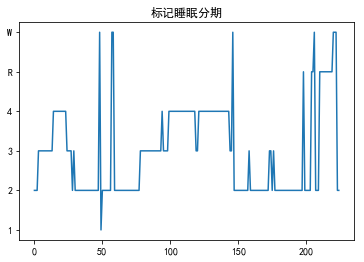

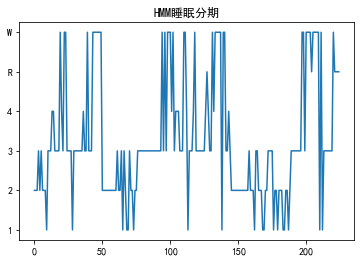

In [251]:
# 在训练集上的准确率 标记数组为states，检测标记为states_test
count = 0
for i in range(len(states)):
    if(states[i] == states_test[i]):
        count+=1
accuracy = count/len(states)
print("accuracy:",accuracy)
# 将数据保存到excel，方便分析
pd.DataFrame(states_test).to_excel("states_test.xlsx",sheet_name="states_test",index=False,header=True)
pd.DataFrame(states).to_excel("states.xlsx",sheet_name="states",index=False,header=True)
plt.plot(states[:225])
plt.title("标记睡眠分期")
plt.show()
plt.plot(states_test[:225])
plt.title("HMM睡眠分期")
plt.show()

In [252]:
# 获取测试数据
file_for_test = 'slp02a'
fid = open(file_test,"w")
print("Writing data of:",file_for_test)
file = os.path.join(cwd, 'slpdb_dl_dir', file_for_test)
data_for_train = write_tag_observation(file)
    
for line in data_for_train:
    fid.write(line[0]+",")
    for content in line[1]:
        fid.write(str(content)+",")
    fid.write("\n")
        
fid.close()
print("\n Done.")

        

Writing data of: slp02a

 Done.


In [253]:

with open(file_test,"r") as fid:
    note = fid.readlines()
    test_tag = []
    T = 960 
    test_data= np.empty((len(note),T))
    i = 0
    for line in note:
        line_new = line.split(",")
        test_tag.append(line_new[0][0])
        test_data[i] = int(line_new[1])
        i+=1
test_data

array([[ 3.,  3.,  3., ...,  3.,  3.,  3.],
       [ 3.,  3.,  3., ...,  3.,  3.,  3.],
       [ 5.,  5.,  5., ...,  5.,  5.,  5.],
       ...,
       [11., 11., 11., ..., 11., 11., 11.],
       [ 9.,  9.,  9., ...,  9.,  9.,  9.],
       [15., 15., 15., ..., 15., 15., 15.]])

In [254]:
# Predict
states_test = []
for obeservation_alone in test_data:
    model_score = np.zeros(6)
    for i in range(6):
        model_name = '%s%d%s'%('model_',i,'.pkl')
    #     model_name = os.path.join(cwd, model_name)
        model = joblib.load(model_name) #调用模型model_i.pkl
        model_score[i] = model.score([obeservation_alone])
#     print(model_score)
    model_score = model_score.tolist()
    states_alone_index = model_score.index(max(model_score))
    states_test_alone = stations[states_alone_index]
    states_test.append(states_test_alone)

accuracy: 0.42318840579710143


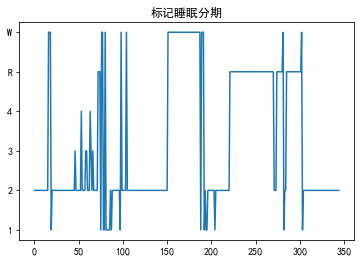

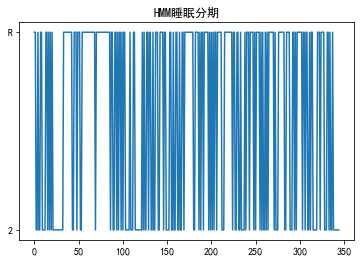

In [255]:
st = test_tag
# 在测试集上的准确率 标记数组为st，检测标记为states_test
count = 0
for i in range(len(st)):
    if(st[i] == states_test[i]):
        count+=1
accuracy = count/len(st)
print("accuracy:",accuracy)
# 将数据保存到excel，方便分析
pd.DataFrame(states_test).to_excel("states_test.xlsx",sheet_name="states_test",index=False,header=True)
pd.DataFrame(st).to_excel("states.xlsx",sheet_name="states",index=False,header=True)

plt.plot(st)
plt.title("标记睡眠分期")
plt.show()

plt.plot(states_test)
plt.title("HMM睡眠分期")
plt.show()